# Lecture 11: Causal Inference and Program Evaluation

- Distinguish prediction from causal inference
- Understand identification assumptions
- Implement common designs: RCT, Difference-in-Differences, Regression Discontinuity, Instrumental Variables
- Interpret estimates and their limitations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

## 1. Prediction vs Causation: selection bias in one picture

We simulate a setting where an unobserved variable influences both treatment and outcomes. A naive regression confuses selection with causality.

In [2]:
# Simulate selection bias
n = 2000
u = np.random.normal(size=n)          # unobserved ability
x = np.random.normal(size=n)           # observed covariate
p = 1 / (1 + np.exp(-(0.8*u + 0.4*x)))  # treatment probability depends on u and x
D = (np.random.uniform(size=n) < p).astype(int)

# True causal effect of treatment
tau = 2.0

# Outcome depends on treatment, observed x, and unobserved u
Y = 1.5*x + 1.0*u + tau*D + np.random.normal(scale=1.0, size=n)

df = pd.DataFrame({"Y": Y, "D": D, "x": x})

ols_naive = smf.ols("Y ~ D", data=df).fit()
ols_controls = smf.ols("Y ~ D + x", data=df).fit()

print("True treatment effect:", tau)
print("Naive OLS estimate:", round(ols_naive.params['D'], 3))
print("OLS with observed control x:", round(ols_controls.params['D'], 3))

True treatment effect: 2.0
Naive OLS estimate: 3.107
OLS with observed control x: 2.731


**Takeaway:** even with controls, unobservables can bias causal estimates. We need designs that generate quasi-random variation.

## 2. Randomized Controlled Trial (RCT)

Random assignment removes selection bias (in expectation). The causal effect is the difference in mean outcomes between treated and control groups.

In [3]:
# Simulate an RCT
n = 2000
D = np.random.binomial(1, 0.5, size=n)
Y0 = np.random.normal(loc=0, scale=1, size=n)  # potential outcomes without treatment
Y1 = Y0 + 1.5                                  # constant treatment effect
Y = Y0 + D * (Y1 - Y0)

rct = pd.DataFrame({"Y": Y, "D": D})

diff_means = rct.groupby("D").Y.mean().diff().iloc[-1]
print("Difference in means (RCT):", round(diff_means, 3))

Difference in means (RCT): 1.451


## 3. Difference-in-Differences (DiD)

Compare changes over time between treated and control groups. Identification requires **parallel trends**.

In [4]:
# Simulate a simple 2x2 DiD
n = 2000
post = np.random.binomial(1, 0.5, size=n)
treated = np.random.binomial(1, 0.5, size=n)

# Parallel trends + treatment effect in post for treated
alpha = 1.0
trend = 0.5
tau = 2.0

Y = alpha + 0.3*treated + trend*post + tau*(treated*post) + np.random.normal(scale=1.0, size=n)

did = pd.DataFrame({"Y": Y, "treated": treated, "post": post})

did_model = smf.ols("Y ~ treated + post + treated:post", data=did).fit()
print(did_model.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9971      0.047     21.306      0.000       0.905       1.089
treated          0.2954      0.064      4.619      0.000       0.170       0.421
post             0.5945      0.066      9.021      0.000       0.465       0.724
treated:post     1.8883      0.091     20.839      0.000       1.711       2.066


The coefficient on `treated:post` is the DiD estimate of the causal effect.

## 4. Regression Discontinuity (RD)

Treatment is assigned when a running variable crosses a cutoff. Identification relies on **local randomization** around the cutoff.

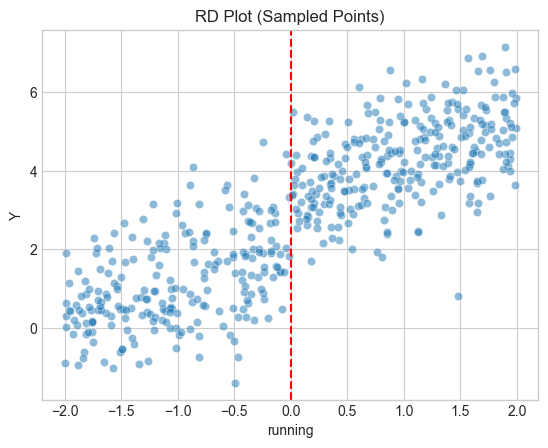

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2682      0.084     26.906      0.000       2.103       2.434
D              1.0205      0.149      6.849      0.000       0.728       1.313
running        1.3912      0.185      7.516      0.000       1.028       1.755


In [5]:
# Simulate RD data
n = 2000
running = np.random.uniform(-2, 2, size=n)
D = (running >= 0).astype(int)

# Outcome has a jump at cutoff
Y = 2 + 0.8*running + 1.5*D + np.random.normal(scale=1.0, size=n)

rd = pd.DataFrame({"Y": Y, "D": D, "running": running})

# Plot
sns.scatterplot(data=rd.sample(500, random_state=1), x="running", y="Y", alpha=0.5)
plt.axvline(0, color="red", linestyle="--")
plt.title("RD Plot (Sampled Points)")
plt.show()

# Local linear regression around cutoff
bandwidth = 0.7
rd_local = rd[np.abs(rd.running) <= bandwidth].copy()
rd_model = smf.ols("Y ~ D + running", data=rd_local).fit()
print(rd_model.summary().tables[1])

The coefficient on `D` in the local regression is the RD estimate.

## 5. Instrumental Variables (IV)

When treatment is endogenous, an instrument can provide exogenous variation. We need:
- **Relevance:** instrument affects treatment
- **Exclusion:** instrument affects outcome only through treatment

In [6]:
# Simulate IV setting
n = 2000
Z = np.random.binomial(1, 0.5, size=n)         # instrument
u = np.random.normal(size=n)                    # unobserved confounder
x = np.random.normal(size=n)                    # observed control

# Endogenous treatment depends on Z and u
D = 0.8*Z + 0.6*u + 0.2*x + np.random.normal(size=n)

# Outcome depends on D and u
tau = 1.5
Y = tau*D + 1.0*u + 0.5*x + np.random.normal(size=n)

iv = pd.DataFrame({"Y": Y, "D": D, "Z": Z, "x": x})

# OLS (biased)
ols = smf.ols("Y ~ D + x", data=iv).fit()
print("OLS estimate:", round(ols.params['D'], 3))

# Manual 2SLS
first_stage = smf.ols("D ~ Z + x", data=iv).fit()
iv["D_hat"] = first_stage.fittedvalues
second_stage = smf.ols("Y ~ D_hat + x", data=iv).fit()
print("2SLS estimate:", round(second_stage.params['D_hat'], 3))

OLS estimate: 1.889
2SLS estimate: 1.557


## 6. Identification Checklist

Before claiming causality, verify:
- What is the source of variation?
- What are the key assumptions (parallel trends, exclusion, continuity, random assignment)?
- Are there plausible threats (selection, spillovers, manipulation, anticipation)?
- Do results survive robustness checks?

## 7. Exercises

1. Modify the DiD simulation to violate parallel trends. What happens to the DiD estimate?
2. In the RD example, change the bandwidth. How sensitive is the estimate?
3. Simulate a weak instrument (reduce the effect of Z on D). What happens to the IV estimate?